In [ ]:
!pip install tensorflow==2.7.0
!pip install tensorflow-quantum==0.7.2

In [4]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [5]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [6]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
x_train = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [8]:
x_test = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

In [9]:
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train = (x_train)/255.0  # Normalize the images to [-1, 1]
x_test = (x_test)/255.0  # Normalize the images to [-1, 1]

print("Number of training examples:", len(x_train))
print("Number of test examples:", len(x_test))

Number of training examples: 60000
Number of test examples: 10000


5


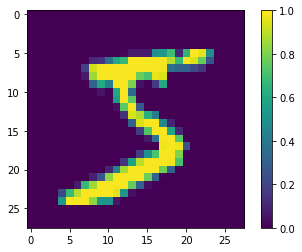

In [10]:
print(train_labels[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

# Downscaling the images 
Because the size 28 x 28 is too large for current quantum computers. So the image needs to be resized to 4 x 4.

In [11]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

5


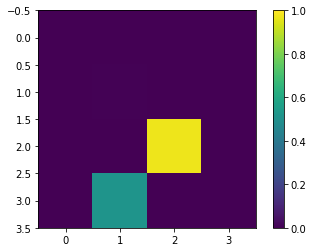

In [12]:
print(train_labels[0])
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Encode data as quantum circuit
Each pixel with a qubit, state depending on the value of the pixel. 
First step, converting to a binary encoding.

In [13]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_small > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [14]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

The circuit created for the first example (circuit diagrams do not show qubits with zero gates):

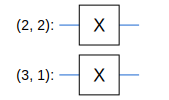

In [15]:
SVGCircuit(x_train_circ[0])

The above circuit can be more easily understood by the looking at the image below, and comparing the positions of the image values which have exceeded the threshold value:

array([[2, 2],
       [3, 1]])

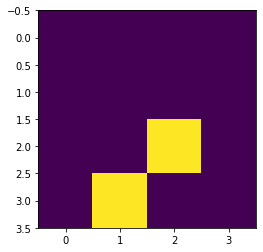

In [16]:
bin_img = x_train_bin[0,:,:,0]
plt.imshow(bin_img)
indices = np.array(np.where(bin_img)).T
indices

Convert the ```Cirq``` circuits to tensors for tfq :

In [17]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Quantum Neural Network

In [18]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

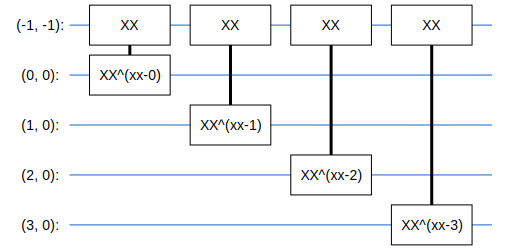

In [19]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [20]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [21]:
model_circuit, model_readout = create_quantum_model()

Wrapping the model in the tfq-keras model

In [22]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [23]:
train_labels_hinge = 2.0*train_labels-1.0
test_labels_hinge = 2.0*test_labels-1.0

In [24]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [25]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


#TRAIN THE MODEL

In [26]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [27]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
train_labels_hinge_sub = train_labels_hinge[:NUM_EXAMPLES]

In [28]:
qnn_history = model.fit(
      x_train_tfcirc_sub, train_labels_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, test_labels_hinge))

qnn_results = model.evaluate(x_test_tfcirc, test_labels)

Epoch 1/3


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1875/1875 [==============================] - ETA: 0s - loss: 0.3079 - hinge_accuracy: 0.8610

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1875/1875 [==============================] - 3400s 2s/step - loss: 0.3079 - hinge_accuracy: 0.8610 - val_loss: 0.1929 - val_hinge_accuracy: 0.9019
Epoch 2/3
1875/1875 [==============================] - 3389s 2s/step - loss: 0.1656 - hinge_accuracy: 0.9008 - val_loss: 0.1482 - val_hinge_accuracy: 0.9017
Epoch 3/3
313/313 [==============================] - 97s 309ms/step - loss: 0.1282 - hinge_accuracy: 0.9017
